In [39]:
#---- Set Up Library ------
from typing import List
import pandas as pd
pd.set_option("display.max_columns",None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [40]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
df = pd.read_csv("/content/drive/MyDrive/INDONESIA AI/DWIMAS ARIE/SALES FORECASTING/store5.csv")

# Data Quality

In [42]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [44]:
# Konversi kolom 'date' menjadi datetime
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

# Hapus fitur yang tidak diperlukan
df.drop(columns=["id", "store_nbr", "dcoilwtico"], inplace=True)


In [45]:
#---- create function for filtering ----
def filter_family(df: pd.DataFrame,family:str) -> pd.DataFrame:
    filtered_df = df[df["family"]==family].reset_index(drop=True)
    return filtered_df


#---- function adfuller test with looping d ---
def adfuller_test(df : pd.Series, p: int) -> None:
    if p == 0:
        result = adfuller(df.dropna())
        print("No Differencing")
        print(f"p-value : {result[1]}")
    else:
        diff_df = df.copy()
        for i in range(p + 1):
            if i == 0:
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")
            else:
                diff_df = diff_df.diff().dropna().reset_index(drop=True)
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")


<Axes: ylabel='family'>

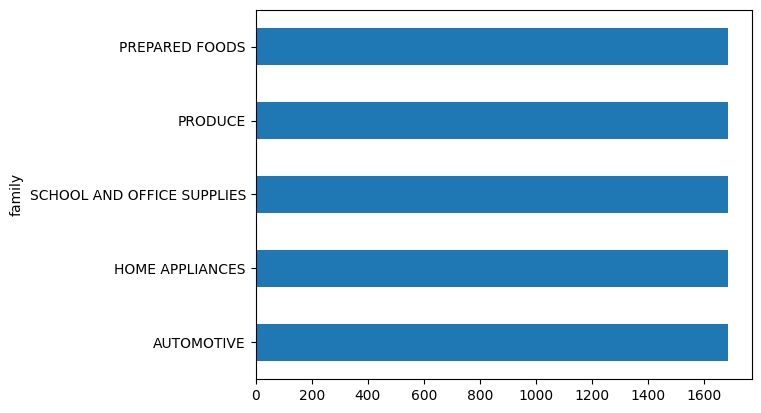

In [46]:
#--- check----
df.family.value_counts().nlargest().plot(kind="barh")

# POULTRY EDA

In [47]:
df_poultry = filter_family(df,"POULTRY")
df_poultry.head()

,date,family,sales,onpromotion
0,2013-01-01,POULTRY,0.00000,0
1,2013-01-02,POULTRY,311.91300,0
2,2013-01-03,POULTRY,196.45900,0
3,2013-01-04,POULTRY,167.29599,0
4,2013-01-05,POULTRY,226.04400,0


<Axes: xlabel='date'>

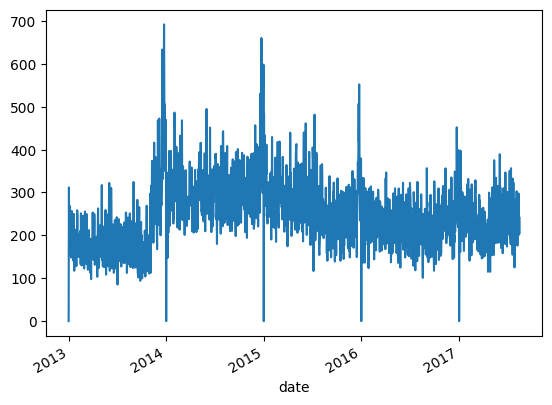

In [48]:
df_poultry.set_index("date").sales.plot()

pada *family prepared food* row index - 0 berisikan 0, sehingga kita akan memfilter row index - 0

<Axes: xlabel='date'>

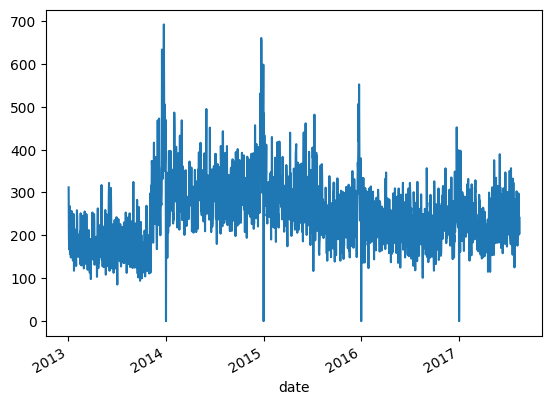

In [49]:
df_poultry.iloc[1:,:].reset_index(drop=True).set_index("date").sales.plot()

<Axes: xlabel='date'>

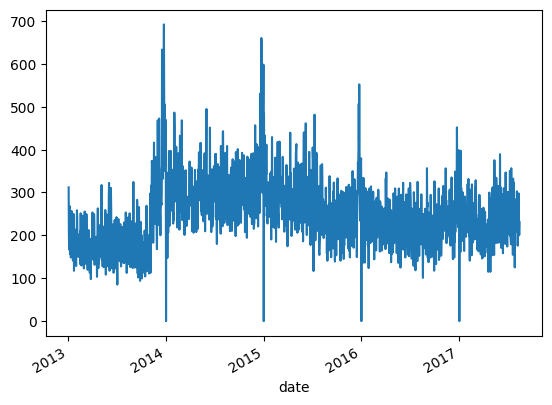

In [50]:
df_poultry = df_poultry.iloc[1:-1,:].reset_index(drop=True)
df_poultry.set_index("date").sales.plot()

Kita mengetahui terdapat pola yang berulang dimana sales dari POULTRY tidak memiliki sales pada tiap awal tahun dan terdapat pola yang seasonal. disini kita akan melakukan pendekatan aggregate perminggu untuk mengatasi data yang 0 pada tiap awal tahun

<Axes: xlabel='date'>

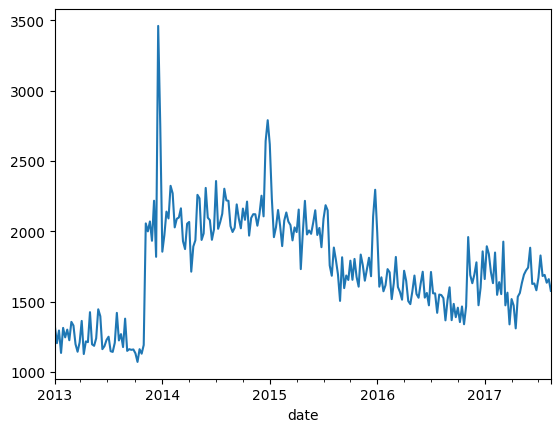

In [51]:
df_poultry.set_index("date").sales.resample("W-MON").sum().plot()

Dengan melakukan aggregate per 1 minggu kita dapat mengatasi kemunculan data 0 pada awal tahun. <br>
Note : kita mengguanakan argument "W-MON" yang mengindikasikan perhitangan 1 minggu dimulai dari hari senin - minggu, jika default menggunakan W maka perhitungan 1 minggu dimulai dari hari minggu - sabtu

In [52]:
# Menetapkan 'date' sebagai indeks
df_poultry.set_index("date", inplace=True)

# Meresample berdasarkan minggu dan menjumlahkan nilai 'sales', tetap mempertahankan kolom lainnya
df_poultry = df_poultry.resample("W-MON").agg({
    'sales': 'sum',
})

df_poultry['sales'] = np.log(df_poultry['sales'])
print(df_poultry.head())


               sales
date                
2013-01-07  7.190568
2013-01-14  7.094783
2013-01-21  7.166572
2013-01-28  7.035306
2013-02-04  7.180741


In [53]:
df_poultry

,sales
date,
2013-01-07,7.190568
2013-01-14,7.094783
2013-01-21,7.166572
2013-01-28,7.035306
2013-02-04,7.180741
...,...
2017-07-17,7.428201
2017-07-24,7.432874
2017-07-31,7.399450


## Uji stationer

In [54]:
# Split data
# Scalling

scaler = MinMaxScaler()
#df_poultry.drop(['family'], axis=1, inplace=True)
x = df_poultry['sales'].copy()

x = scaler.fit_transform(x.values.reshape(-1, 1))

In [55]:
def load_data(X, seq_len, train_size=0.8):
    amount_of_features = X.shape[1]
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X) - sequence_length):
        data.append(X[index: index + sequence_length])

    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1]

    x_test = data[train_split:, :-1]
    y_test = data[train_split:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 22
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(174, 22, 1) (174, 1) (44, 22, 1) (44, 1)


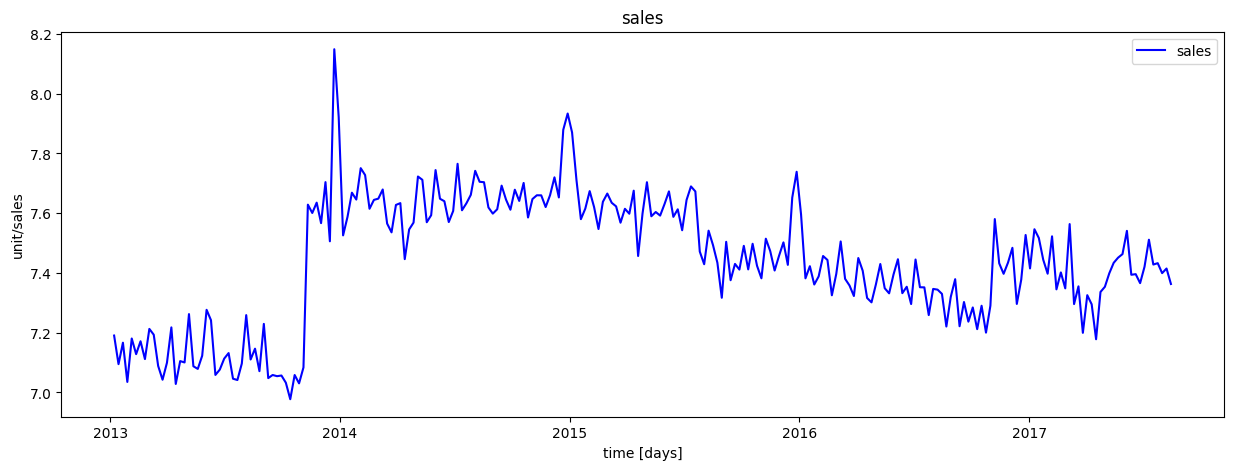

In [56]:
plt.figure(figsize=(15, 5));
plt.plot(df_poultry['sales'], color='blue', label='sales')

#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('sales')
plt.xlabel('time [days]')
plt.ylabel('unit/sales')
plt.legend(loc='best')
plt.show()

In [57]:
#LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, input_shape=(window,1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
LSTM=model.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
5/5 [==============================] - 3s 216ms/step - loss: 0.2233 - val_loss: 0.0635
Epoch 2/100
5/5 [==============================] - 0s 35ms/step - loss: 0.1936 - val_loss: 0.0454
Epoch 3/100
5/5 [==============================] - 0s 30ms/step - loss: 0.1385 - val_loss: 0.0125
Epoch 4/100
5/5 [==============================] - 0s 31ms/step - loss: 0.0448 - val_loss: 0.0590
Epoch 5/100
5/5 [==============================] - 0s 34ms/step - loss: 0.0397 - val_loss: 0.0260
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0193 - val_loss: 0.0034
Epoch 7/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0254 - val_loss: 0.0052
Epoch 8/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0192 - val_loss: 0.0206
Epoch 9/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0189 - val_loss: 0.0262
Epoch 10/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0190 - val_loss: 0.0110
Epoch 11/100
5/5 [

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13001 (50.79 KB)
Trainable params: 13001 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

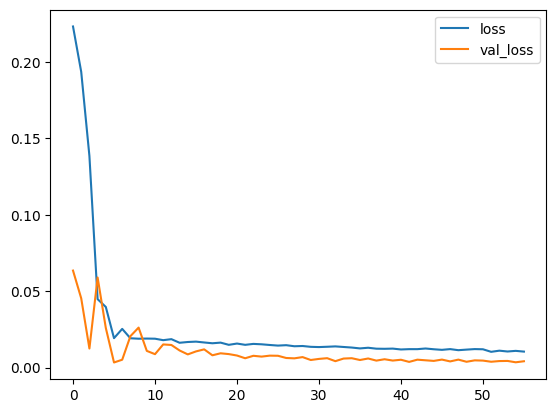

In [59]:
%matplotlib inline
losses = pd.DataFrame(LSTM.history)
losses.plot()

# model predict

In [60]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

2/2 [==============================] - 0s 7ms/step


In [61]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(44, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(44, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

(44, 1)
(44, 1)


In [62]:
df_poultry.shape

(241, 1)

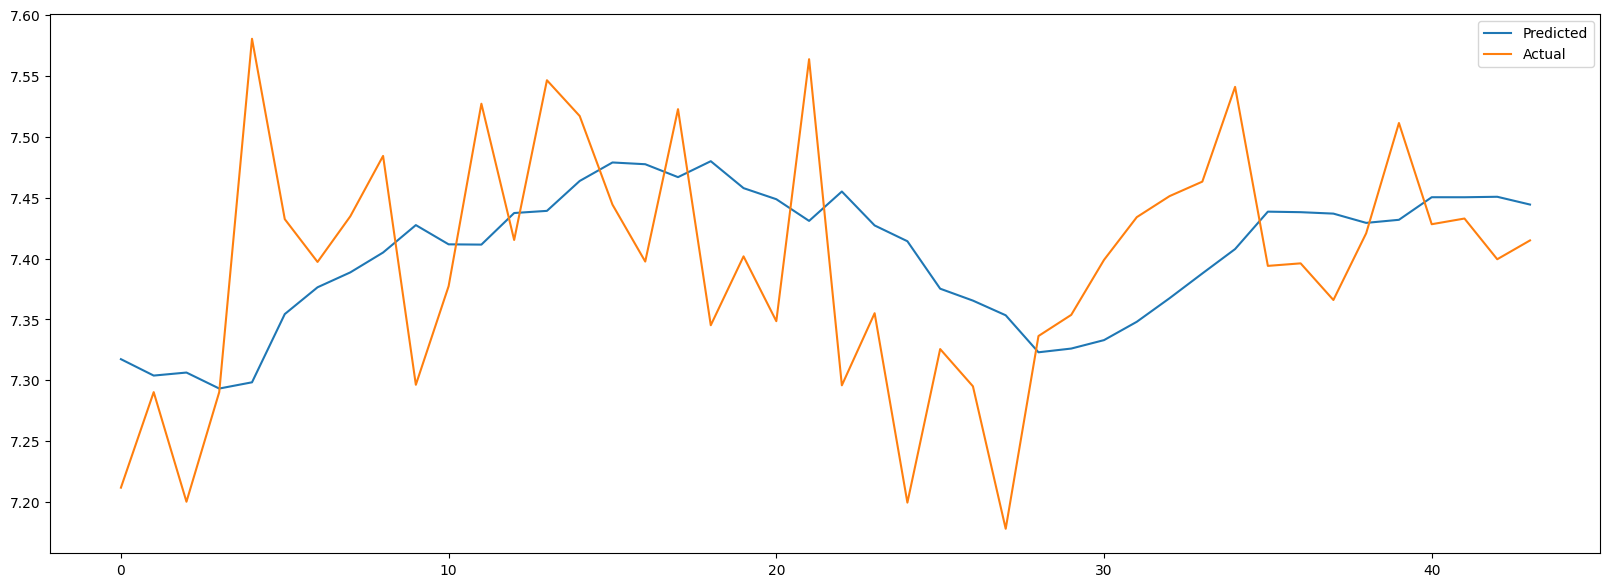

In [63]:
plot_x = df['date'].copy()
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-44:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [64]:
trainScore = mean_squared_error(trainY, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.12 RMSE
Test Score: 0.10 RMSE


In [65]:
poultry_sales = df_poultry.sales.values.astype('float32')
poultry_sales = poultry_sales.reshape(len(poultry_sales), 1)
trainPredictPlot = np.empty_like(poultry_sales)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+ 22, :] = trainPredict
testPredictPlot = np.empty_like(poultry_sales)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(poultry_sales) - testPredict.shape[0]):len(poultry_sales), :] = testPredict

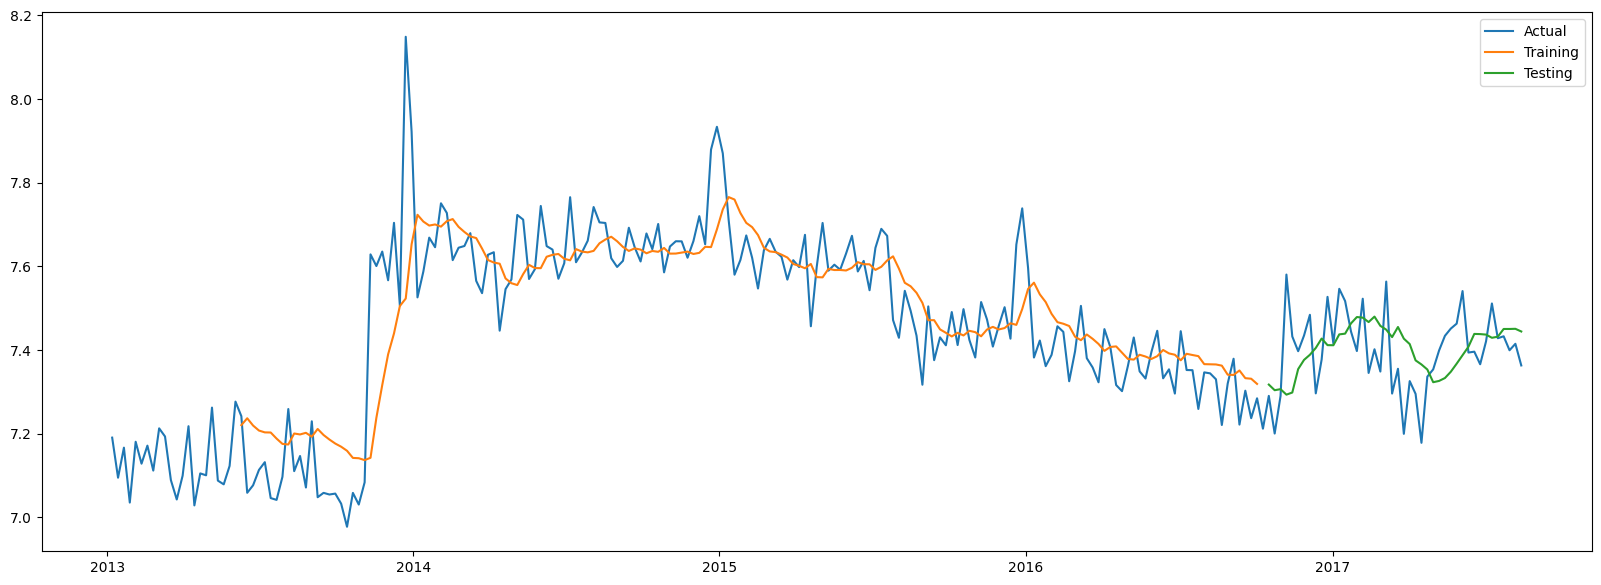

In [66]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(poultry_sales, columns=["sales"], index=df_poultry.index).sales, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["sales"], index=df_poultry.index).sales, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["sales"], index=df_poultry.index).sales, label='Testing')
plt.legend(loc='best')
plt.show()

# Model - GRU

In [67]:
# Stack LSTM architecture
model2 = Sequential()
# GRU layer with Dropout regularisation
model2.add(GRU(units=20, input_shape=(window,1)))
model2.add(Dropout(0.2))

# The output layer
model2.add(Dense(units=20, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history2=model2.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
5/5 [==============================] - 4s 214ms/step - loss: 0.2243 - val_loss: 0.0675
Epoch 2/100
5/5 [==============================] - 0s 32ms/step - loss: 0.2102 - val_loss: 0.0602
Epoch 3/100
5/5 [==============================] - 0s 33ms/step - loss: 0.1938 - val_loss: 0.0511
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1715 - val_loss: 0.0394
Epoch 5/100
5/5 [==============================] - 0s 31ms/step - loss: 0.1415 - val_loss: 0.0252
Epoch 6/100
5/5 [==============================] - 0s 32ms/step - loss: 0.1048 - val_loss: 0.0101
Epoch 7/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0615 - val_loss: 0.0022
Epoch 8/100
5/5 [==============================] - 0s 31ms/step - loss: 0.0262 - val_loss: 0.0223
Epoch 9/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0226 - val_loss: 0.0484
Epoch 10/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0259 - val_loss: 0.0322
Epoch 11/100
5/5 [

<Axes: >

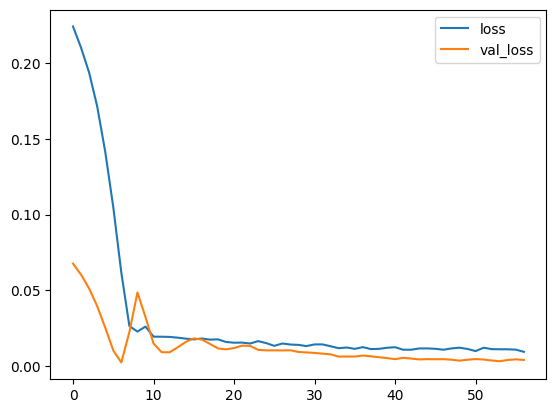

In [68]:
%matplotlib inline
losses = pd.DataFrame(history2.history)
losses.plot()

In [69]:
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

2/2 [==============================] - 0s 7ms/step


In [70]:
trainScore = mean_squared_error(trainY, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.11 RMSE
Test Score: 0.09 RMSE


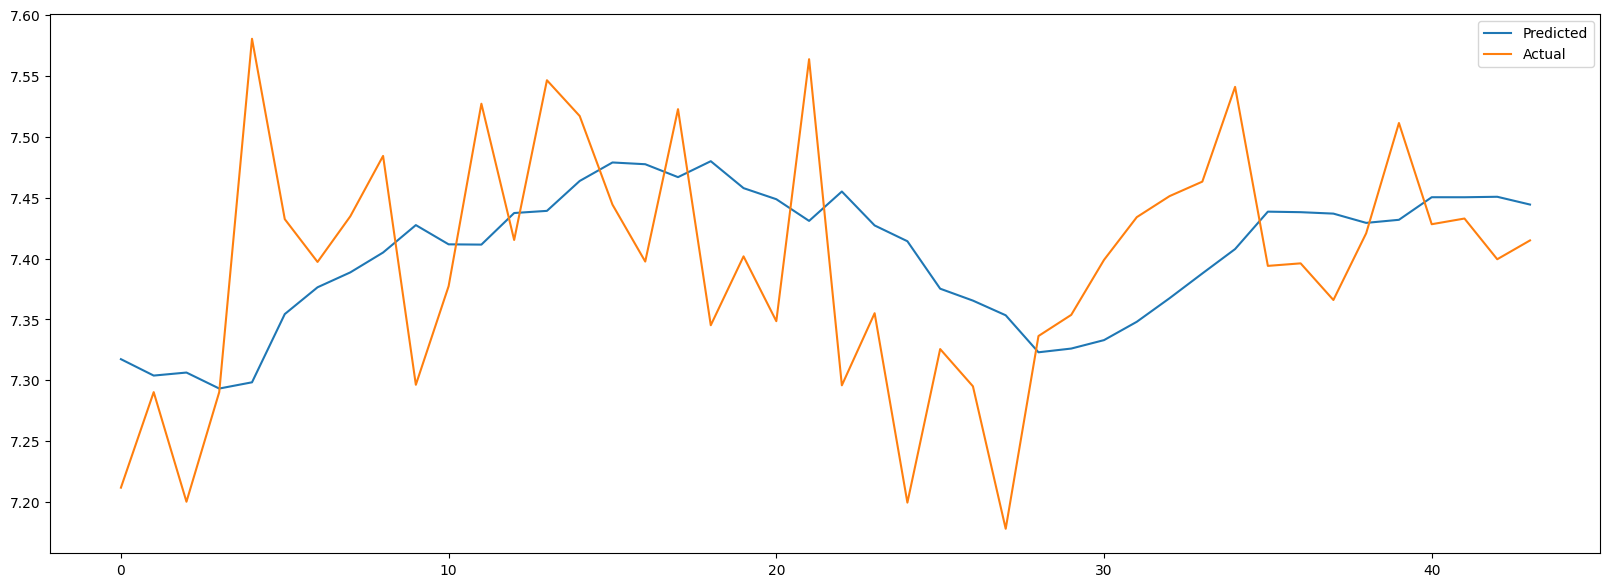

In [71]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()